In [35]:
# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

import warnings
warnings.filterwarnings("ignore")

In [36]:
# Téléchargement des données historiques
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'BRK-B', 'JNJ', 'V', 'NVDA']
benchmark_ticker = '^GSPC'  # S&P 500
start_date = "2015-01-01"
end_date = "2024-11-30"

# Téléchargement des données de clôture ajustée
data = yf.download(tickers + [benchmark_ticker], start=start_date, end=end_date)['Adj Close']
returns = data[tickers].pct_change().dropna()
sp500_returns = data[benchmark_ticker].pct_change().dropna()

# Séparation des périodes in-sample et out-of-sample
split_date = "2019-01-01"
returns_in = returns.loc[:split_date]
returns_out = returns.loc[split_date:]

[*********************100%%**********************]  10 of 10 completed


In [37]:
# Fonction Markowitz avec coûts linéaires
def markowitz_linear(returns, lin_cost, risk_target):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    portfolio_return = mu @ w
    portfolio_risk = cvx.quad_form(w, Sigma)
    transaction_cost = lin_cost @ cvx.abs(w)
    objective = cvx.Maximize(portfolio_return - transaction_cost)
    constraints = [cvx.sum(w) == 1, portfolio_risk <= risk_target**2, w >= 0]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [38]:
# Fonction Markowitz avec maximisation des rendements
def markowitz_max_return(returns):
    n = returns.shape[1]
    mu = returns.mean().values  # Rendements moyens des actifs
    # Variable d'optimisation
    w = cvx.Variable(n)
    # Fonction objectif : maximiser le rendement total
    objective = cvx.Maximize(mu @ w)
    # Contraintes : somme des poids = 1 et poids >= 0
    constraints = [
        cvx.sum(w) == 1,
        w >= 0
    ]
    # Résolution du problème d'optimisation
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [39]:
# Fonction Markowitz maximisant l'utilité
def markowitz_utility(returns, risk_aversion):
    n = returns.shape[1]
    mu = returns.mean().values
    Sigma = returns.cov().values
    w = cvx.Variable(n)
    utility = mu @ w - risk_aversion / 2 * cvx.quad_form(w, Sigma)
    constraints = [cvx.sum(w) == 1, w >= 0]
    problem = cvx.Problem(cvx.Maximize(utility), constraints)
    problem.solve(solver=cvx.ECOS)
    return pd.Series(w.value, index=returns.columns)

In [40]:
# Fonction ERC
def computeERC(Sigma):
    Sigma = np.array(Sigma)
    n = np.shape(Sigma)[0]
    x0 = np.ones((n, 1)) / n
    x = x0 * 10
    var = np.diag(Sigma)
    Sx = Sigma.dot(x)
    convergence = False
    while not convergence:
        for i in range(n):
            alpha = var[i]
            beta = (Sx[i] - x[i] * var[i])[0]
            gamma_ = -1.0 / n
            x_tilde = (-beta + np.sqrt(beta**2 - 4 * alpha * gamma_)) / (2 * alpha)
            x[i] = x_tilde
            Sx = Sigma.dot(x)
        convergence = np.sum((x / np.sum(x) - x0 / np.sum(x0))**2) <= 1e-5
        x0 = x.copy()
    return (x / x.sum()).flatten()


In [41]:
# ------------------------------- HRP ------------------------------
# Fonction pour calculer la distance basée sur la corrélation
def correlDist(corr):
    """
    Calcule la matrice de distance basée sur la corrélation.
    """
    dist = ((1 - corr) / 2) ** 0.5
    return dist

# Fonction pour afficher le dendrogramme avec la matrice de corrélation réorganisée
def plotDendrogramWithHeatmap(corr):
    """
    Affiche un dendrogramme couplé à la matrice de corrélation sous forme de heatmap.
    """
    # Étape 1 : Calcul de la distance et clustering hiérarchique
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')
    
    # Étape 2 : Création de la figure avec le dendrogramme et la heatmap
    fig = plt.figure(figsize=(20, 10))
    
    # Ajout du dendrogramme (en haut)
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.8])
    dendro = sch.dendrogram(link, orientation='left', labels=corr.columns, ax=ax1, leaf_font_size=10)
    ax1.set_title("Dendrogramme des actifs")

    # Réorganisation de la matrice de corrélation
    idx = dendro['leaves']
    corr_reordered = corr.iloc[idx, idx]

    # Ajout de la heatmap (à droite)
    ax2 = fig.add_axes([0.35, 0.1, 0.6, 0.8])
    cax = ax2.matshow(corr_reordered, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(cax, ax=ax2)
    
    ax2.set_xticks(range(len(corr.columns)))
    ax2.set_xticklabels(corr_reordered.columns, rotation=90, fontsize=10)
    ax2.set_yticks(range(len(corr.columns)))
    ax2.set_yticklabels(corr_reordered.columns, fontsize=10)
    ax2.set_title("Matrice de corrélation réorganisée")

    plt.tight_layout()
    plt.savefig("Dendrogram_Heatmap_Correlation.png")
    plt.show()

# Fonction pour afficher la matrice de corrélation sous forme de heatmap simple
def plotCorrMatrix(path, corr, labels=None):
    if labels is None:
        labels = []
    plt.figure(figsize=(20, 10))
    plt.pcolor(corr, cmap="coolwarm")
    plt.colorbar()
    plt.yticks(np.arange(0.5, corr.shape[0] + 0.5), labels)
    plt.xticks(np.arange(0.5, corr.shape[0] + 0.5), labels, rotation=90)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

# Fonction pour afficher le dendrogramme
def plotDendrogram(corr):
    """
    Affiche uniquement le dendrogramme.
    """
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')

    plt.figure(figsize=(10, 6))
    sch.dendrogram(link, labels=corr.columns, orientation='top', leaf_font_size=10)
    plt.title("Dendrogramme des actifs")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.savefig("HRP_Dendrogram.png")
    plt.show()

# Fonction pour afficher la heatmap de corrélation réorganisée
def plotReorderedHeatmap(corr):
    """
    Affiche uniquement la matrice de corrélation réorganisée.
    """
    # Étape 1 : Clustering hiérarchique
    dist = correlDist(corr)
    dist_condensed = ssd.squareform(dist)
    link = sch.linkage(dist_condensed, method='single')
    dendro = sch.dendrogram(link, no_plot=True)

    # Étape 2 : Réorganisation de la matrice
    idx = dendro['leaves']
    corr_reordered = corr.iloc[idx, idx]

    # Étape 3 : Affichage de la heatmap
    plt.figure(figsize=(8, 6))
    plt.matshow(corr_reordered, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    plt.title("Matrice de corrélation réorganisée", pad=20)
    plt.xticks(range(len(corr.columns)), corr_reordered.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr_reordered.columns)
    plt.tight_layout()
    plt.savefig("HRP_Reordered_Heatmap.png")
    plt.show()

# Fonction pour afficher la matrice de corrélation simple
def plotCorrMatrix(path, corr, labels=None):
    """
    Affiche la heatmap simple de la matrice de corrélation.
    """
    if labels is None:
        labels = corr.columns
    plt.figure(figsize=(8, 6))
    plt.pcolor(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.yticks(np.arange(0.5, corr.shape[0] + 0.5), labels)
    plt.xticks(np.arange(0.5, corr.shape[0] + 0.5), labels, rotation=90)
    plt.title("Matrice de corrélation")
    plt.tight_layout()
    plt.savefig(path)
    plt.show()



# Tri quasi-diagonal pour ordonner les actifs
def getQuasiDiag(link):
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)
        df0 = sortIx[sortIx >= numItems]
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0]).sort_index()
        sortIx.index = range(sortIx.shape[0])
    return sortIx.tolist()

# Calcul de la variance par cluster
def getClusterVar(cov, cItems):
    cov_ = cov.loc[cItems, cItems]
    ivp = 1 / np.diag(cov_)
    ivp /= ivp.sum()
    cVar = np.dot(np.dot(ivp.T, cov_), ivp)
    return cVar

# Allocation bipartite récursive pour HRP
def getRecBipart(cov, sortIx):
    sortIx = [cov.columns[int(i)] for i in sortIx]
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]
        for i in range(0, len(cItems), 2):
            cVar0 = getClusterVar(cov, cItems[i])
            cVar1 = getClusterVar(cov, cItems[i + 1])
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems[i]] *= alpha
            w[cItems[i + 1]] *= 1 - alpha
    return w


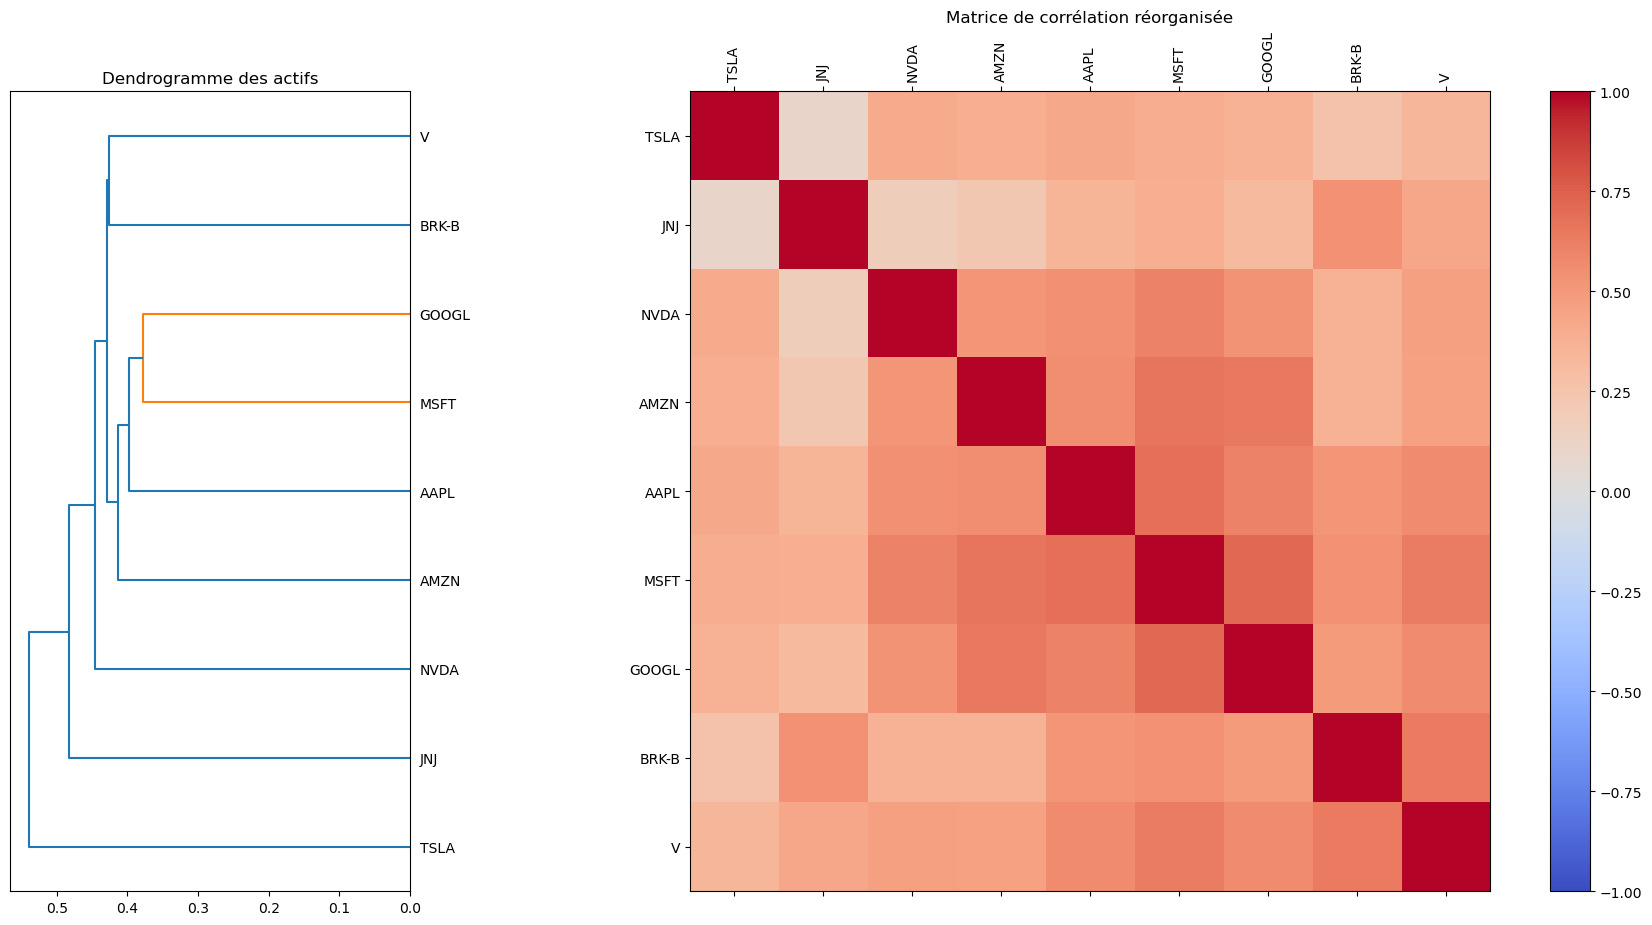


Allocation HRP :
TSLA     0.038687
JNJ      0.386020
NVDA     0.038376
AMZN     0.084534
AAPL     0.078642
MSFT     0.086636
GOOGL    0.090977
BRK-B    0.120637
V        0.075491
dtype: float64


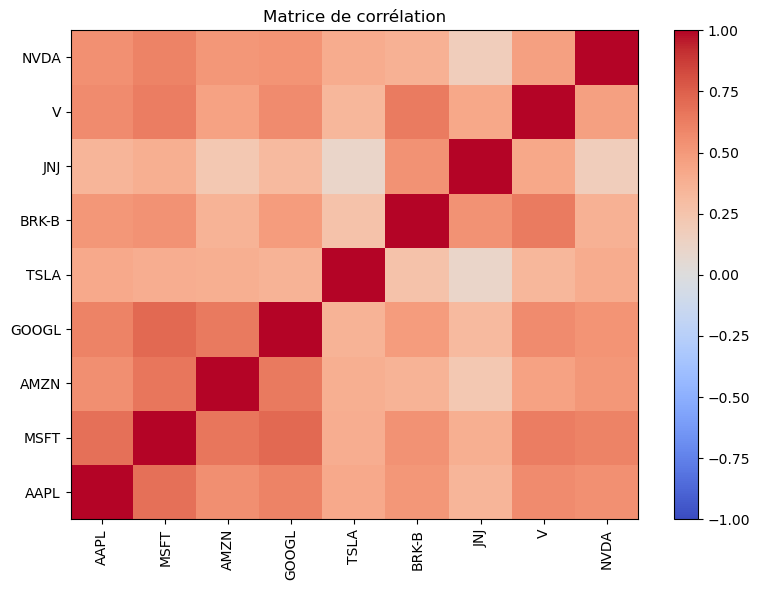

In [42]:
# Calcul des matrices de corrélation et covariance
corr = returns.corr()
cov = returns.cov()

# Étape 1 : Conversion en matrice de distances condensée
dist = correlDist(corr)
dist_condensed = ssd.squareform(dist)

# Étape 2 : Clustering hiérarchique
link = sch.linkage(dist_condensed, 'single')

# Étape 3 : Affichage du dendrogramme couplé à la heatmap de corrélation
plotDendrogramWithHeatmap(corr)

# Étape 4 : Tri quasi-diagonal
sortIx = getQuasiDiag(link)

# Étape 5 : Allocation HRP
hrp = getRecBipart(cov, sortIx)
print("\nAllocation HRP :")
print(hrp)

# Affichage de la matrice de corrélation seule
plotCorrMatrix("HRP_CorrMatrix.png", corr, labels=corr.columns)


In [49]:
# Calcul des portefeuilles in-sample
cov_in = returns_in.cov()
lin_cost = np.full(returns_in.shape[1], 0.001)  # Coût linéaire
risk_target = 0.02
risk_aversion = 5

weights_hrp = getRecBipart(cov, sortIx)
#weights_max_return = markowitz_max_return(returns_in)
weights_linear = markowitz_linear(returns_in, lin_cost, risk_target)
weights_utility = markowitz_utility(returns_in, risk_aversion)
weights_erc = computeERC(cov_in)
weights_equal = np.ones(len(tickers)) / len(tickers)

In [50]:
# Backtest out-of-sample
returns_out_cum = pd.DataFrame({
    "Markowitz Transaction Cost": (returns_out @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_out @ weights_utility).cumsum(),
    "ERC": (returns_out @ weights_erc).cumsum(),
    "Equal Weight": (returns_out @ weights_equal).cumsum(),
    "HRP Weight": (returns_out @ weights_hrp).cumsum(),
    "S&P 500": sp500_returns.loc[returns_out.index].cumsum()
})

# Backtest in-sample
returns_in_cum = pd.DataFrame({
    "Markowitz Transaction Cost": (returns_in @ weights_linear).cumsum(),
    "Markowitz Utility": (returns_in @ weights_utility).cumsum(),
    "ERC": (returns_in @ weights_erc).cumsum(),
    "Equal Weight": (returns_in @ weights_equal).cumsum(),
    "HRP Weight": (returns_in @ weights_hrp).cumsum(),
    "S&P 500": sp500_returns.loc[returns_in.index].cumsum()
})

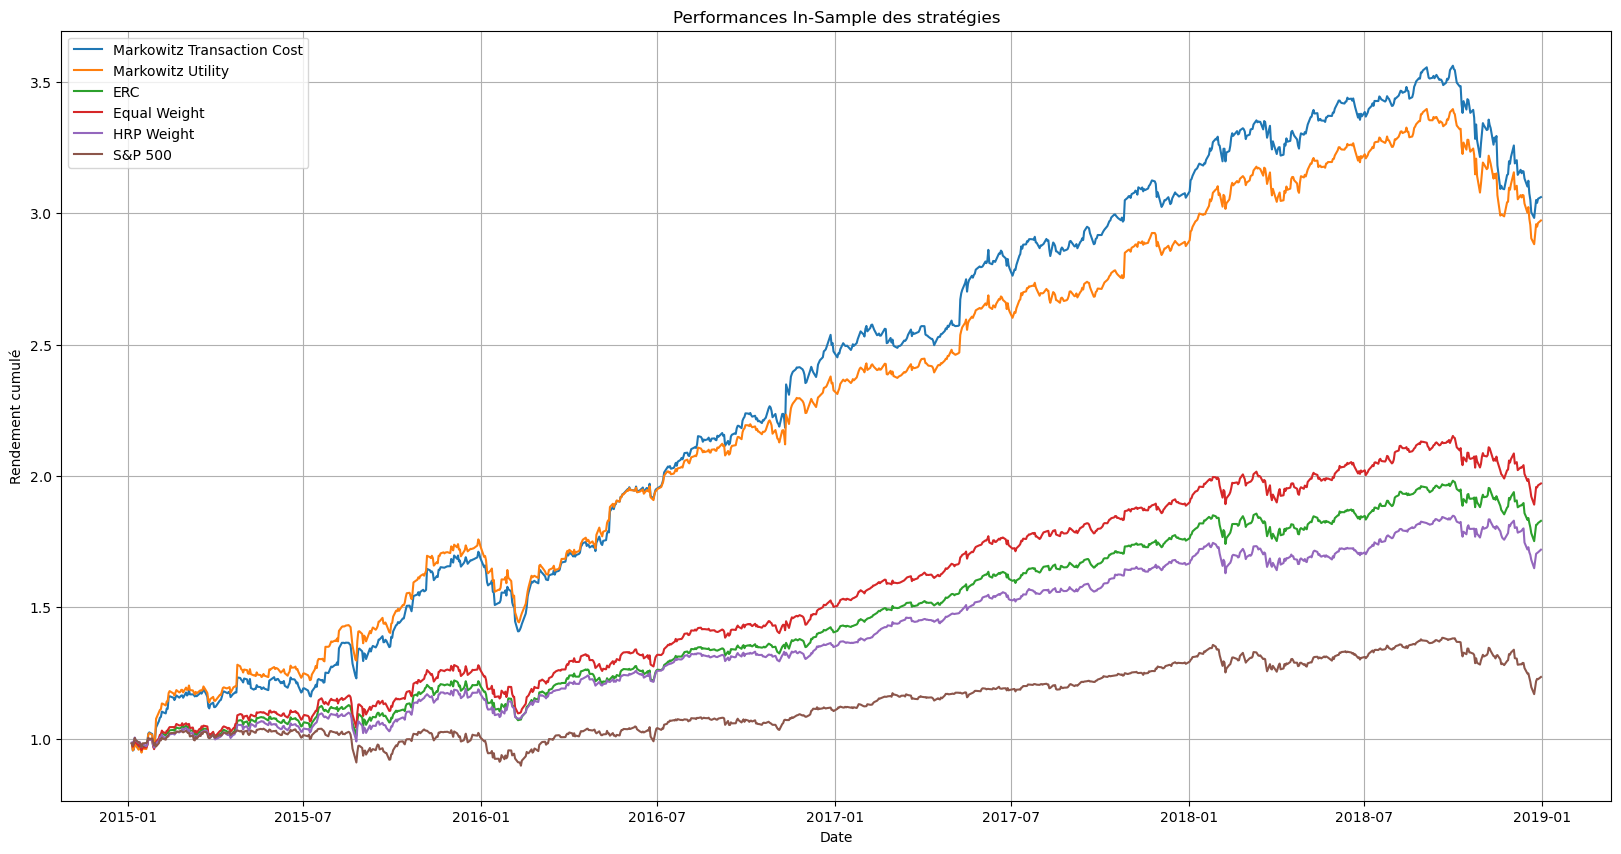

In [51]:
# Visualisation des performances In-Sample
plt.figure(figsize=(20, 10))
for col in returns_in_cum.columns:
    plt.plot(1+returns_in_cum[col], label=col)
plt.title("Performances In-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

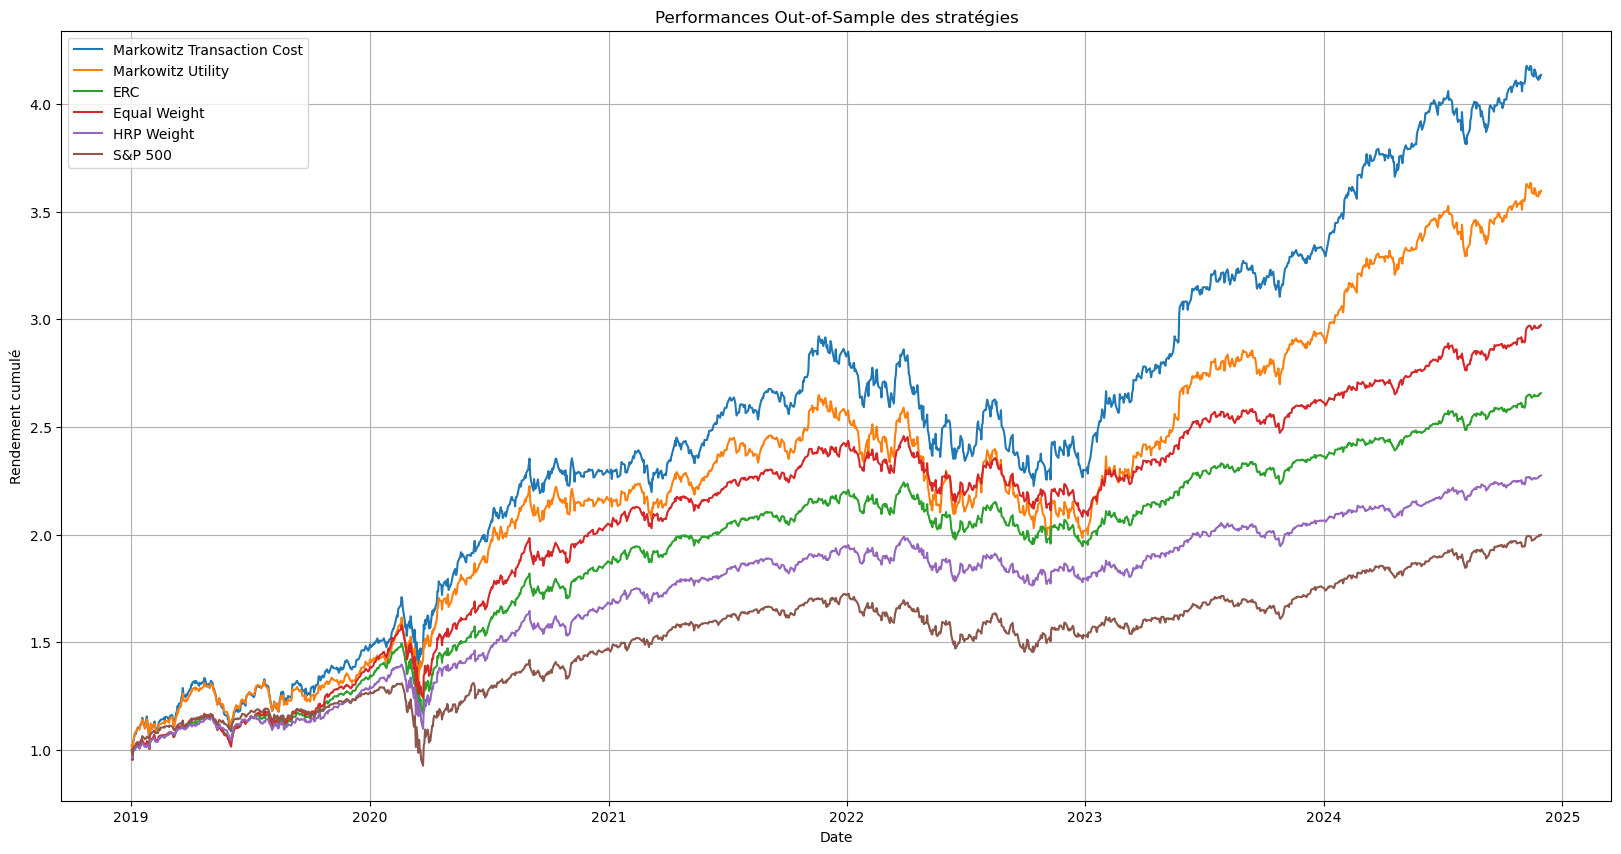

In [52]:
# Visualisation des performances Out-of-Sample
plt.figure(figsize=(20, 10))
for col in returns_out_cum.columns:
    plt.plot(1+returns_out_cum[col], label=col)
plt.title("Performances Out-of-Sample des stratégies")
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.legend()
plt.grid()
plt.show()

In [53]:
# Statistiques de performance
def performance_stats(returns):
    """
    Calcule les statistiques de performance :
    - Mean Return annualisé
    - Volatilité annualisée
    - Ratio de Sharpe
    - Cumulative Return
    """
    mean_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = mean_return / volatility
    cumulative_return = returns.sum()
    return {"Mean Return": mean_return, "Volatility": volatility, 
            "Sharpe Ratio": sharpe_ratio, "Cumulative Return": cumulative_return}

# Appliquer la fonction aux rendements journaliers
stats = pd.DataFrame({col: performance_stats(returns_out_cum[col].diff().dropna()) 
                      for col in returns_out_cum.columns}).T

# Afficher les statistiques
print("Statistiques de performance :")
stats


Statistiques de performance :


,Mean Return,Volatility,Sharpe Ratio,Cumulative Return
Markowitz Transaction Cost,0.527121,0.398193,1.323784,3.112525
Markowitz Utility,0.435840,0.365962,1.190941,2.573529
ERC,0.281224,0.222640,1.263135,1.660563
Equal Weight,0.334717,0.253107,1.322429,1.976421
HRP Weight,0.216420,0.193107,1.120724,1.277907
S&P 500,0.169048,0.202048,0.836675,0.998189
